# CS445: Term Project

#### Victor Weeks & Josh Lutz

## Introduction

## Data

In [1]:
from gw2spidy import Gw2Spidy as spidy # allows retrieval of market information
import numpy as np
import json
import random
import neuralnetworksA4 as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
itemIDs = (19718,19720,19697,19680,19719,19738,19723,19710,
           19739,19740,19699,19683,19703,19687,19728,19733,19726,19713,
           19741,19742,19698,19682,19730,19734,19727,19714,
           19743,19744,19702,19686,19731,19736,19736,19724,19711,
           19748,19747,19700,19684,19729,19735,19722,19709,
           19745,19746,19701,19685,19732,19737,19725,19712)

In [3]:
itemTimeData = np.load('itemData.npy')
itemTimeData.shape

(13362, 13)

In [4]:
names = ['item_id', 'max_offer_price', 'min_sale_price', 'offer_availability', 'sale_availability', 'sale_price_change', 'offer_price_change', 'year', 'month', 'day', 'hour', 'minute', 'second']

In [20]:
Xnames = names[1:7]
Tnames = names[1:7]

In [113]:
def makeItemData(itemID=19718, allItems=False, splitData=False, stepsAheadToPredict=4):
    itemTimeData = np.load('itemData.npy')
    if allItems:
        itemData = np.mean(itemTimeData[0:50], axis=0).reshape((1,-1))
        for bucket in itemTimeData[51::51]:
            itemData = np.vstack((itemData, np.mean(bucket.reshape((1,-1)), axis=0).reshape((1,-1))))
    else:
        itemData = itemTimeData[np.where(itemTimeData[:]==itemID)[0]]
    X = itemData[:-stepsAheadToPredict, 1:7].copy()
    T = itemData[stepsAheadToPredict:, 1:7].copy()
    if splitData:
        rows = np.arange(X.shape[0])
        nTrain = int(X.shape[0] * 0.7)
        Xtrain = X[rows[:nTrain],:]
        Ttrain = T[rows[:nTrain],:]
        Xtest = X[rows[nTrain:],:]
        Ttest = T[rows[nTrain:],:]
        return Xtrain, Ttrain, Xtest, Ttest
    else:        
        return X, T, itemData

Note: Had to make sure to copy the X and T data because of how the Time-Embedded data is accessed.

In [186]:
Xtrain, Ttrain, items = makeItemData(allItems=True, stepsAheadToPredict=8) # training with all items
Xtest, Ttest, item1 = makeItemData(19718, stepsAheadToPredict=8)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((265, 6), (265, 6), (265, 6), (265, 6))

In [156]:
Xtrain, Ttrain, Xtest, Ttest = makeItemData(19722, splitData=True, stepsAheadToPredict=24)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((170, 6), (170, 6), (73, 6), (73, 6))

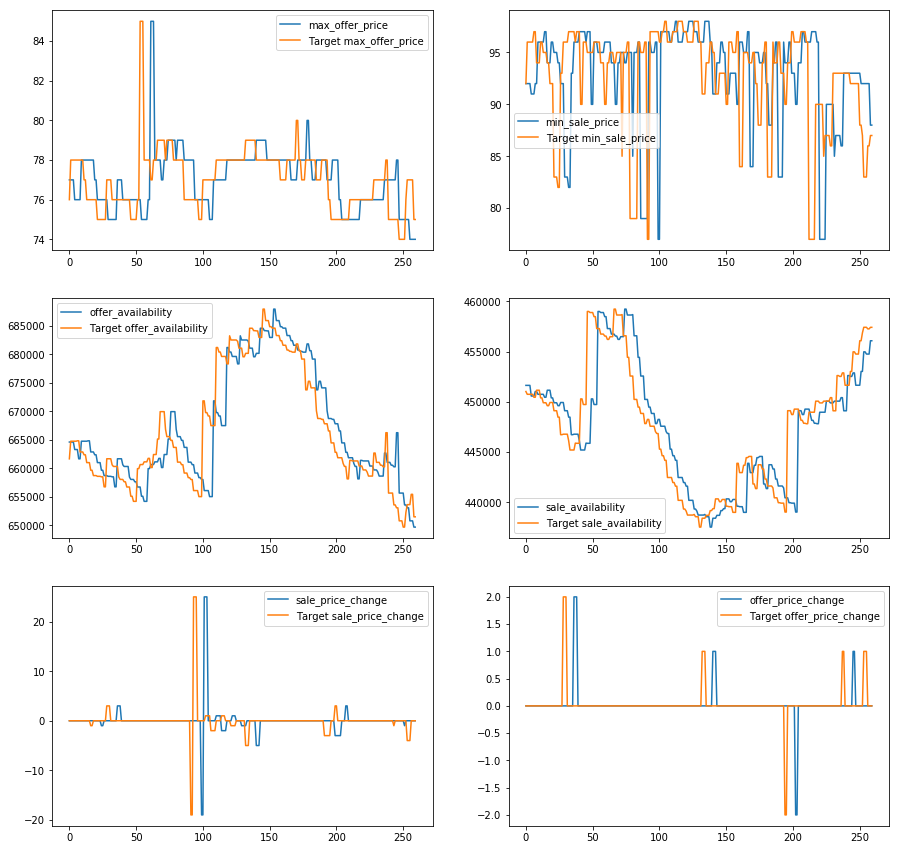

In [165]:
fig = plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
plt.plot(Xtest[:,0], label=Xnames[0])
plt.plot(Ttest[:,0], label='Target ' + Tnames[0])
plt.legend();

plt.subplot(3,2,2)
plt.plot(Xtest[:,1], label=Xnames[1])
plt.plot(Ttest[:,1], label='Target ' + Tnames[1])
plt.legend();

plt.subplot(3,2,3)
plt.plot(Xtest[:,2], label=Xnames[2])
plt.plot(Ttest[:,2], label='Target ' + Tnames[2])
plt.legend();

plt.subplot(3,2,4)
plt.plot(Xtest[:,3], label=Xnames[3])
plt.plot(Ttest[:,3], label='Target ' + Tnames[3])
plt.legend();

plt.subplot(3,2,5)
plt.plot(Xtest[:,4], label=Xnames[4])
plt.plot(Ttest[:,4], label='Target ' + Tnames[4])
plt.legend();

plt.subplot(3,2,6)
plt.plot(Xtest[:,5], label=Xnames[5])
plt.plot(Ttest[:,5], label='Target ' + Tnames[5])
plt.legend();

## Methods

### Time-Embedding

In [15]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

In [32]:
def rollingWindows(X, windowSize=4):    
    nSamples, nAttributes = X.shape
    nWindows = nSamples - windowSize + 1
    # Shape of resulting matrix
    newShape = (nWindows, nAttributes * windowSize)
    itemSize = X.itemsize  # number of bytes
    # Number of bytes to increment to starting element in each dimension
    strides = (nAttributes * itemSize, itemSize)
    return np.lib.stride_tricks.as_strided(X, shape=newShape, strides=strides)

In [187]:
XtrainW = rollingWindows(Xtrain, windowSize=9)
XtestW = rollingWindows(Xtest, windowSize=9)
TtrainW = Ttrain[:XtrainW.shape[0]]
TtestW = Ttest[:XtestW.shape[0]]
XtrainW.shape, TtrainW.shape, XtestW.shape, TtestW.shape

((257, 54), (257, 6), (257, 54), (257, 6))

In [88]:
import pandas as pd
def getBestAvgNeuralStructure(Xtrain,Xtest,Ttrain,Ttest,nIterations=1000,timesToAvg=5,plot=False):
    errors = []
    hiddens = [0] + [[nu] * nl for nu in [1, 5, 10, 20, 50] for nl in [1, 2, 3, 4, 5]]
    for hids in hiddens:
        errorTrain = 0
        errorTest = 0
        errorAvg = 0
        for _ in range(timesToAvg):
            nnet = nn.NeuralNetwork(Xtrain.shape[1], hids, Ttrain.shape[1])
            nnet.train(Xtrain, Ttrain, nIterations)
            errorTrain += rmse(Ttrain, nnet.use(Xtrain))
            errorTest += rmse(Ttest, nnet.use(Xtest))
            errorAvg = (errorTrain + errorTest)/2
        errors.append([hids,errorTrain/timesToAvg,errorTest/timesToAvg,errorAvg/timesToAvg])
    errors = pd.DataFrame(errors)
    print(errors)
    if plot==True:
        plt.figure(figsize=(10, 10))
        plt.plot(errors.values[:, 1:], 'o-')
        plt.title('RMSE Values for Neural Net')
        plt.legend(('Train', 'Test', 'Avg Error'))
        plt.xticks(range(errors.shape[0]), hiddens, rotation=30, horizontalalignment='right')
        plt.grid(True)
    minErrorAverage = errors[3].min()
    minIndex = list(errors[3]).index(minErrorAverage)
    bestHids = errors[0][minIndex]
    print('Lowest average error over',timesToAvg,'fully trained iterations:',bestHids,'with error:',minErrorAverage)
    return bestHids

1.96166388442e-16
7.27569768465e-17
1.80170725987e-16
8.97100761791e-17
1.90436365574e-16
6.37455949974e-17
1.48470405062e-16
                       0            1            2            3
0                      0     0.000354     0.000354     0.000354
1                    [1]  1961.016922  1961.365609  1961.191265
2                 [1, 1]  1961.460413  1961.983642  1961.722028
3              [1, 1, 1]  1962.341273  1962.992834  1962.667053
4           [1, 1, 1, 1]  1963.087217  1963.921364  1963.504290
5        [1, 1, 1, 1, 1]  2124.900145  2125.539005  2125.219575
6                    [5]  1399.053606  1399.329377  1399.191492
7                 [5, 5]  1418.511548  1419.015467  1418.763507
8              [5, 5, 5]  1468.842219  1473.522668  1471.182443
9           [5, 5, 5, 5]  1419.972439  1421.621765  1420.797102
10       [5, 5, 5, 5, 5]  1626.677328  1627.950728  1627.314028
11                  [10]    22.406915    34.802843    28.604879
12              [10, 10]    75.849072   15

0

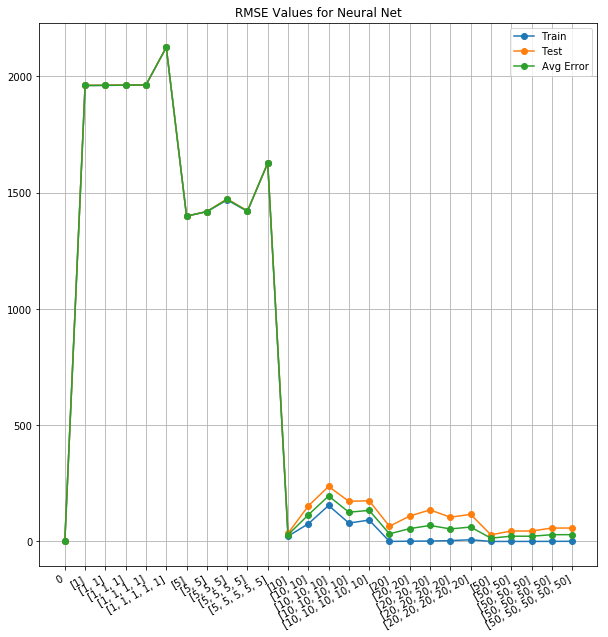

In [172]:
getBestAvgNeuralStructure(XtrainW,XtestW,TtrainW,TtestW,2000,5,True)

In [324]:
def compareItemToMarket(itemID=19718, allItems=False, stepsAheadToPredict=8, windowSize=9):
    # get data
    if allItems:
        Xtrain, Ttrain, allItems = makeItemData(allItems=allItems, stepsAheadToPredict=stepsAheadToPredict) # training with all items
        Xtest, Ttest, itemTest = makeItemData(itemID, stepsAheadToPredict=stepsAheadToPredict)        
    else: 
        Xtrain, Ttrain, Xtest, Ttest = makeItemData(itemID, splitData=True, stepsAheadToPredict=stepsAheadToPredict)
        
    Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape
    
    # apply rolling windows to data
    XtrainW = rollingWindows(Xtrain, windowSize=windowSize)
    XtestW = rollingWindows(Xtest, windowSize=windowSize)
    TtrainW = Ttrain[:XtrainW.shape[0]]
    TtestW = Ttest[:XtestW.shape[0]]
    XtrainW.shape, TtrainW.shape, XtestW.shape, TtestW.shape
    
    # build and train net
    nnet = nn.NeuralNetwork(XtrainW.shape[1], [10], TtrainW.shape[1])
    nnet.train(XtrainW, TtrainW, 2000, verbose=True)

    fig = plt.figure(figsize=(15,15))
    plt.subplot(4,2,1)
    plt.plot(nnet.getErrors())
    print(nnet)

    Ytrain = nnet.use(XtrainW)
    Y = nnet.use(XtestW)

    plt.subplot(4,2,3)
    plt.plot(Y[:,0], label='Predicted ' + Tnames[0])
    plt.plot(TtestW[:,0], label='Target ' + Tnames[0])
    plt.legend();

    plt.subplot(4,2,4)
    plt.plot(Y[:,1], label='Predicted ' + Tnames[1])
    plt.plot(TtestW[:,1], label='Target ' + Tnames[1])
    plt.legend();

    plt.subplot(4,2,5)
    plt.plot(Y[:,2], label='Predicted ' + Tnames[2])
    plt.plot(TtestW[:,2], label='Target ' + Tnames[2])
    plt.legend();

    plt.subplot(4,2,6)
    plt.plot(Y[:,3], label='Predicted ' + Tnames[3])
    plt.plot(TtestW[:,3], label='Target ' + Tnames[3])
    plt.legend();

    plt.subplot(4,2,7)
    plt.plot(Y[:,4], label='Predicted ' + Tnames[4])
    plt.plot(TtestW[:,4], label='Target ' + Tnames[4])
    plt.legend();

    plt.subplot(4,2,8)
    plt.plot(Y[:,5], label='Predicted ' + Tnames[5])
    plt.plot(TtestW[:,5], label='Target ' + Tnames[5])
    plt.legend();

    print("")
    print("Final RMSEs")
    print(Tnames[0], " Train: ", rmse(Ytrain[:,0], TtrainW[:,0]), " Test: ", rmse(Y[:,0], TtestW[:,0]))
    print(Tnames[1], " Train: ", rmse(Ytrain[:,1], TtrainW[:,1]), " Test: ", rmse(Y[:,1], TtestW[:,1]))
    print(Tnames[2], " Train: ", rmse(Ytrain[:,2], TtrainW[:,2]), " Test: ", rmse(Y[:,2], TtestW[:,2]))
    print(Tnames[3], " Train: ", rmse(Ytrain[:,3], TtrainW[:,3]), " Test: ", rmse(Y[:,3], TtestW[:,3]))
    print(Tnames[4], " Train: ", rmse(Ytrain[:,4], TtrainW[:,4]), " Test: ", rmse(Y[:,4], TtestW[:,4]))
    print(Tnames[5], " Train: ", rmse(Ytrain[:,5], TtrainW[:,5]), " Test: ", rmse(Y[:,5], TtestW[:,5]))

SCG: Iteration 200 fValue Eval 0.000718838472984 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.000274821346936 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.000162473962152 Scale 1e-15
SCG: Iteration 800 fValue Eval 0.000115055586868 Scale 1e-15
SCG: Iteration 1000 fValue Eval 7.81066567841e-05 Scale 1e-15
SCG: Iteration 1200 fValue Eval 6.53047907857e-05 Scale 1e-15
SCG: Iteration 1400 fValue Eval 6.11062588994e-05 Scale 1e-15
SCG: Iteration 1600 fValue Eval 5.24049508358e-05 Scale 1e-15
SCG: Iteration 1800 fValue Eval 3.92619801545e-05 Scale 1e-15
SCG: Iteration 2000 fValue Eval 3.52285419464e-05 Scale 1e-15
NeuralNetwork(54, [10], 6)
   Network was trained for 2001 iterations that took 4.3137 seconds. Final error is 0.005935363674313496.

Final RMSEs
max_offer_price  Train:  0.0155874155179  Test:  0.01567727122
min_sale_price  Train:  0.0477721313122  Test:  0.04777688657
offer_availability  Train:  74.4650432714  Test:  74.5862981019
sale_availability  Train:  44.6995313691  Test:  

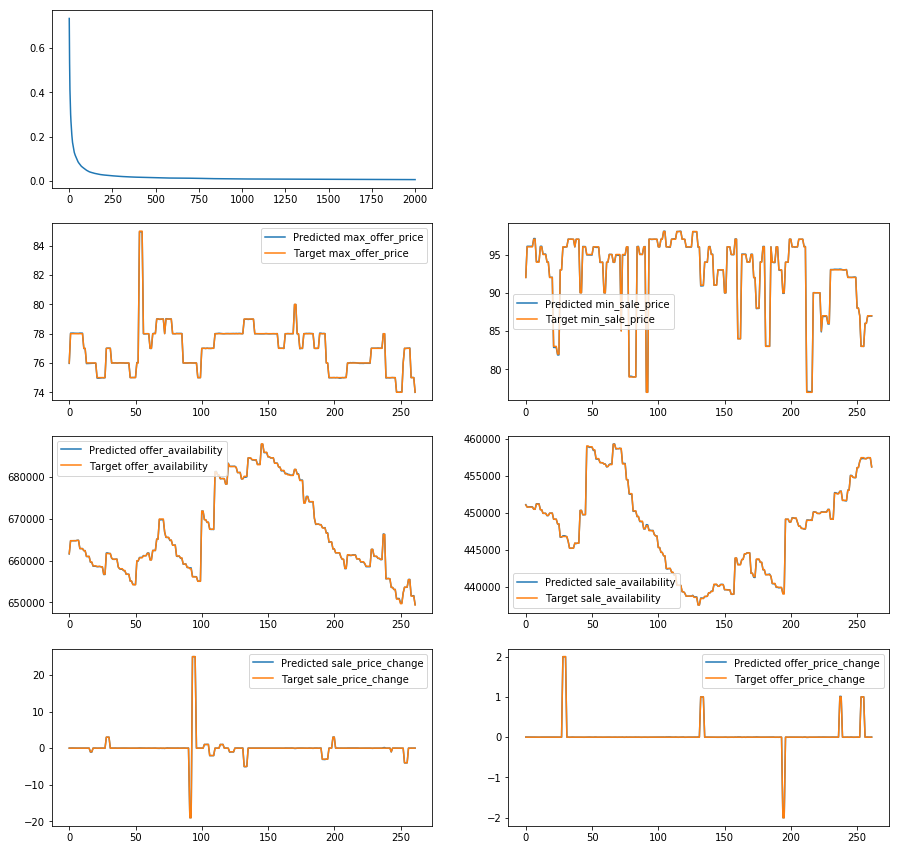

In [326]:
compareItemToMarket(itemID=19718, allItems=True)

SCG: Iteration 200 fValue Eval 0.000830467291558 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.000239629790457 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.000128110640141 Scale 1e-15
SCG: Iteration 800 fValue Eval 9.23221279504e-05 Scale 1e-15
SCG: Iteration 1000 fValue Eval 6.04616335732e-05 Scale 1e-15
SCG: Iteration 1200 fValue Eval 4.59295262549e-05 Scale 1e-15
SCG: Iteration 1400 fValue Eval 4.12503433835e-05 Scale 1e-15
SCG: Iteration 1600 fValue Eval 3.47631004406e-05 Scale 1e-15
SCG: Iteration 1800 fValue Eval 2.83731611457e-05 Scale 1e-15
SCG: Iteration 2000 fValue Eval 2.57354846887e-05 Scale 1e-15
NeuralNetwork(54, [10], 6)
   Network was trained for 2001 iterations that took 3.5737 seconds. Final error is 0.005073015344809512.

Final RMSEs
max_offer_price  Train:  0.0123836860711  Test:  0.20667136954
min_sale_price  Train:  0.0335614478814  Test:  0.829424095171
offer_availability  Train:  74.7865681133  Test:  1533.60587951
sale_availability  Train:  46.5603153019  Test: 

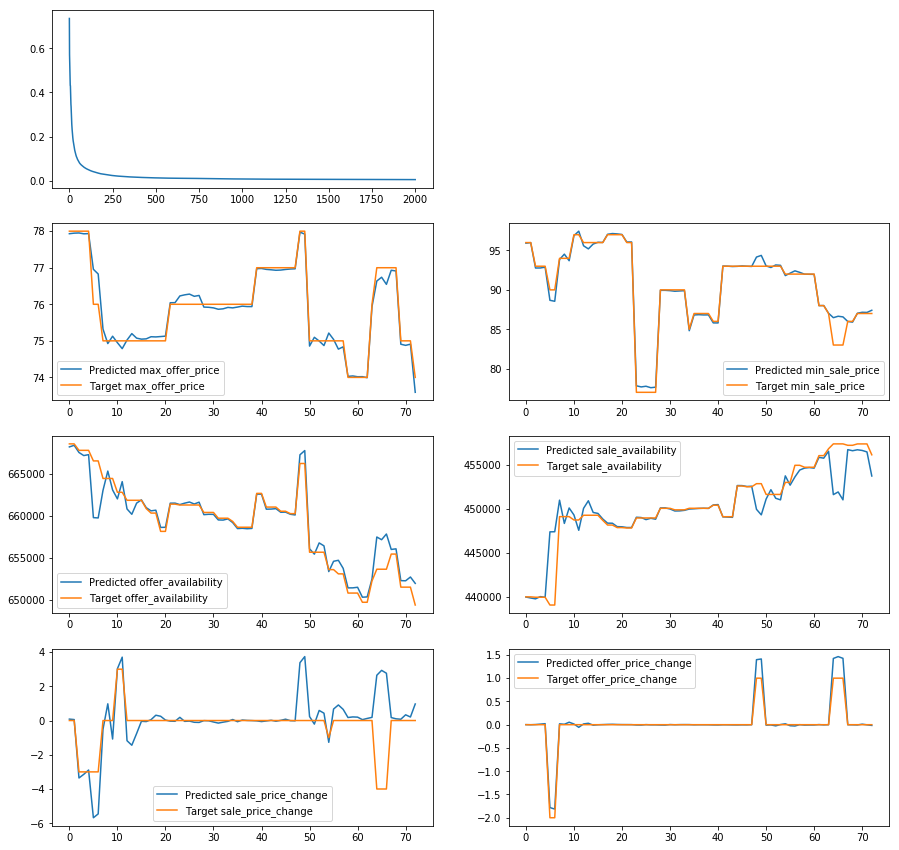

In [327]:
compareItemToMarket(itemID=19718, allItems=False)

In [215]:
def compareAllToMarket():

    nnet = nn.NeuralNetwork(XtrainW.shape[1], [10], TtrainW.shape[1])
    nnet.train(XtrainW, TtrainW, 2000)
    print(nnet)

    allErrors = np.array([float('inf')]*6)

    for id in itemIDs:   
        Xtest, Ttest, item1 = makeItemData(id, stepsAheadToPredict=8)
        XtestW = rollingWindows(Xtest, windowSize=9)
        TtestW = Ttest[:XtestW.shape[0]]

        Y = nnet.use(XtestW)
        errors = []

        errors = np.array([rmse(Y[:,0], TtestW[:,0]), rmse(Y[:,1], TtestW[:,1]), rmse(Y[:,2], TtestW[:,2]), rmse(Y[:,3], TtestW[:,3]), rmse(Y[:,4], TtestW[:,4]), rmse(Y[:,5], TtestW[:,5])]).reshape(1,6)
        allErrors = np.vstack((allErrors, errors))
    lowestErrors = np.amin(allErrors, axis=0)
        
    return (allErrors, lowestErrors)

NeuralNetwork(54, [10], 6)
   Network was trained for 2001 iterations that took 3.9023 seconds. Final error is 0.005778141422447662.


In [ ]:
allErrors, lowestErrors = compareAllToMarket()

## Results

For some reason, giving a window size of 1 timepoint larger than the steps ahead to predict gives best accuracy

## Conclusions

## References

## Word Count

In [1340]:
import io
from IPython.nbformat import current
import glob
nbfile = glob.glob('TermProject.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file TermProject.ipynb is 63
